In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/experiments/data"
X, y = get_data("sdpa_backward", base_dir, sample_rate=1.0)
X.info()

24it [00:31,  1.29s/it]
100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464256 entries, 0 to 464255
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   b                  464256 non-null  int64  
 1   h                  464256 non-null  int64  
 2   s_q                464256 non-null  int64  
 3   s_kv               464256 non-null  int64  
 4   d_qk               464256 non-null  int64  
 5   d_v                464256 non-null  int64  
 6   gflops             464256 non-null  float64
 7   dtype_16           464256 non-null  bool   
 8   dtype_32           464256 non-null  bool   
 9   dtype_b16          464256 non-null  bool   
 10  backend_cudnn      464256 non-null  bool   
 11  backend_efficient  464256 non-null  bool   
 12  backend_flash      464256 non-null  bool   
 13  is_causal_0        464256 non-null  bool   
 14  is_causal_1        464256 non-null  bool   
dtypes: bool(8), float64(1), int64(6)
memory usage: 28.3

In [3]:
df = pd.concat([X, y], axis=1)
df = df.dropna()
df = df[df["time"] > 0]
X, y = df.drop(columns=["time"]), df["time"]

In [9]:
n_iter = 20

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(random_state=random_seed)

param_dist = {
    "max_depth": [30, 50, 80, 100],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [2, 5],
    "max_features": [10, 50, 100, 1.0, "sqrt"],
    "n_estimators": [10, 30, 50, 100],
}

randomized_search = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=param_dist,
    n_iter=n_iter,  # Number of iterations to perform
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    random_state=random_seed,
    n_jobs=3,
)

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 100, 'max_depth': 50}
Best MSE found:  -83.89934896462987
Train--------
Mean Squared Error: 24.13157002413331
MAPE: 0.017829455579368613
R-squared: 0.9974921701079782


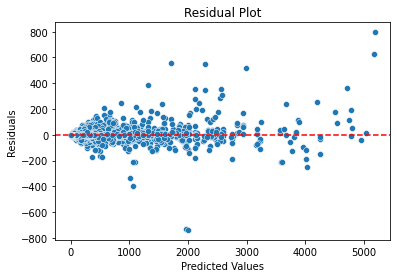

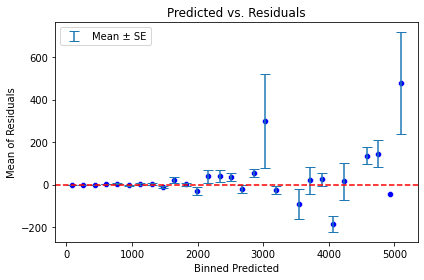

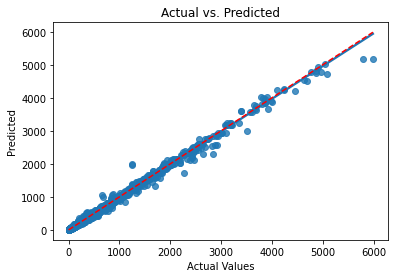

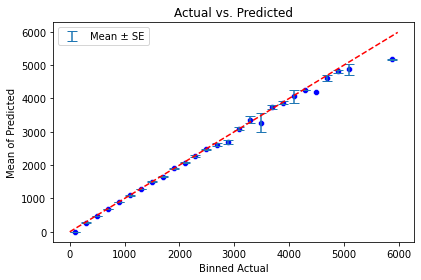

Val--------
Mean Squared Error: 54.77648069490325
MAPE: 0.0305269397846064
R-squared: 0.9935935612061231


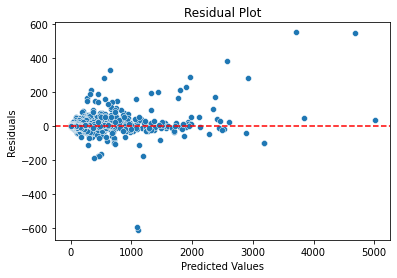

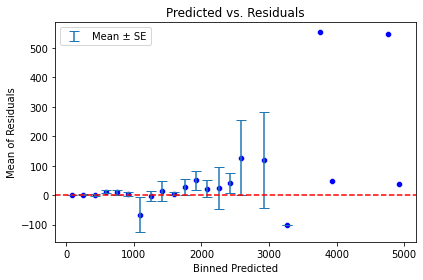

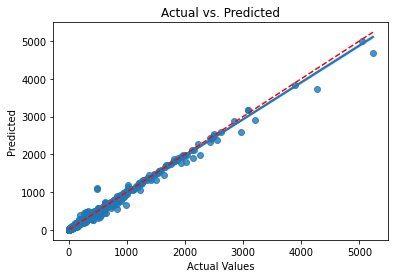

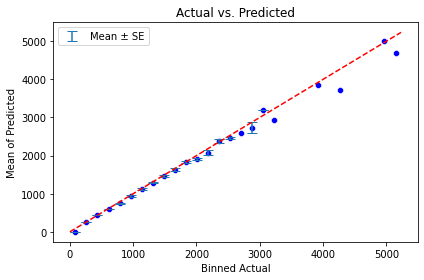

In [10]:
randomized_search.fit(X_cv, y_cv)
print("Best parameters found: ", randomized_search.best_params_)
print("Best MSE found: ", randomized_search.best_score_)

best_tree_model = randomized_search.best_estimator_
best_tree_model.fit(X_cv, y_cv)
run_val_pipeline(best_tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [12]:
import joblib
joblib.dump(best_tree_model, '../../h100_models/sdpa_backward.joblib')

['../../h100_models/sdpa_backward.joblib']